In [1]:
import pandas as pd
import numpy as np
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

sns.set_style("whitegrid")

In [2]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

#office
train = pd.read_csv("train.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])
test = pd.read_csv("test.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'id'])

train = train.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})

test = test.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})



#set a unique id for each client, product combination (thanks Gemini)
combined_df = pd.concat([train,test])
combined_df['ID'] = combined_df.groupby(['Client_ID', 'Product_ID']).ngroup()

train = combined_df.iloc[:len(train)].copy()
test = combined_df.iloc[len(train):].copy()

del combined_df


train = train.drop(columns='id')
train['adjusted_demand'] = train['adjusted_demand'].astype(int)
train = train.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

test = test.drop(columns='adjusted_demand')
test['id'] = test['id'].astype(int)
test = test.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

In [3]:
#create a dataframe of aggregate statistics for each client

testagg = train.groupby('Client_ID').agg({'Product_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

client_stats = pd.DataFrame()

client_stats['Client_ID'] = train['Client_ID'].unique()
client_stats['Products'] = testagg['Product_ID']['nunique']
client_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
client_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
client_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
client_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
client_stats['adj_dem_max'] = testagg['adjusted_demand']['max']

client_stats.head()

,Client_ID,Products,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,26,51,28.10,20,26.62,0,132
1,60,34,188.83,130,228.27,11,2304
2,65,112,109.10,60,140.54,0,1669
3,101,4,81.60,28,86.40,20,280
4,105,72,50.36,26,57.83,2,459


In [5]:
#verify client_stats is working as intended

cid = train['Client_ID'].unique().tolist()
testcids = np.random.choice(cid, size=50)

for i in testcids:
    assert(len(train[train['Client_ID'] == i]['Product_ID'].unique()) == client_stats[client_stats['Client_ID'] == i]['Products'].iloc[0])
    assert(train[train['Client_ID'] == i]['adjusted_demand'].mean().round(2) == client_stats[client_stats['Client_ID'] == i]['adj_dem_mean'].iloc[0])

In [41]:
#create a dataframe of aggregate statistics for each product
del testagg
testagg = train.sort_values(by=['Product_ID']).groupby('Product_ID').agg({'Client_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

product_stats = pd.DataFrame()

product_stats['Product_ID'] = train.sort_values(by=['Product_ID'])['Product_ID'].unique()
product_stats['Clients'] = testagg['Client_ID']['nunique']
product_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
product_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
product_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
product_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
product_stats['adj_dem_max'] = testagg['adjusted_demand']['max']

product_stats.head()

,Product_ID,Clients,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,41,15,367.44,70,532.94,0,2064
1,53,45,291.10,119,409.19,0,1919
2,72,67417,4.90,4,5.16,0,659
3,73,59643,3.19,2,7.71,0,450
4,100,40,8.81,3,11.83,0,52


In [45]:
#verify product_stats is working as intended

pid = train['Product_ID'].unique().tolist()
testpids = np.random.choice(pid, size=25)

for i in testpids:
    assert(len(train[train['Product_ID'] == i]['Client_ID'].unique()) == product_stats[product_stats['Product_ID'] == i]['Clients'].iloc[0])
    assert(train[train['Product_ID'] == i]['adjusted_demand'].mean().round(2) == product_stats[product_stats['Product_ID'] == i]['adj_dem_mean'].iloc[0])

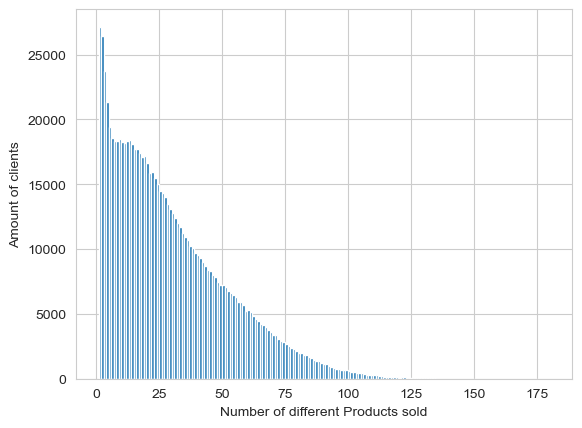

In [58]:
plt.hist(client_stats['Products'], bins=np.arange(1,len(client_stats['Products'].unique())))

plt.ylabel("Amount of clients")
plt.xlabel("Number of different Products sold")


plt.show()

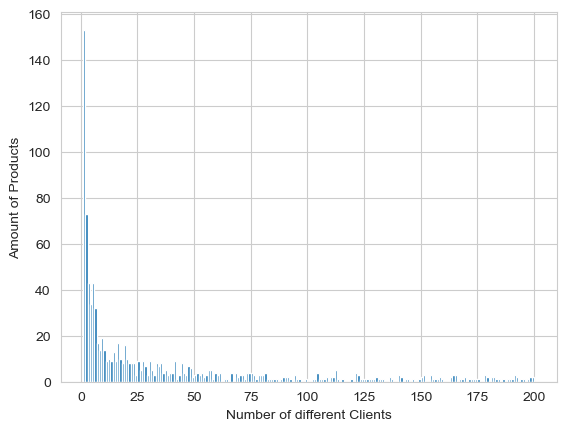

In [60]:
plt.hist(product_stats['Clients'], bins=np.linspace(1,200,200))

plt.xlabel("Number of different Clients")
plt.ylabel("Amount of Products")


plt.show()

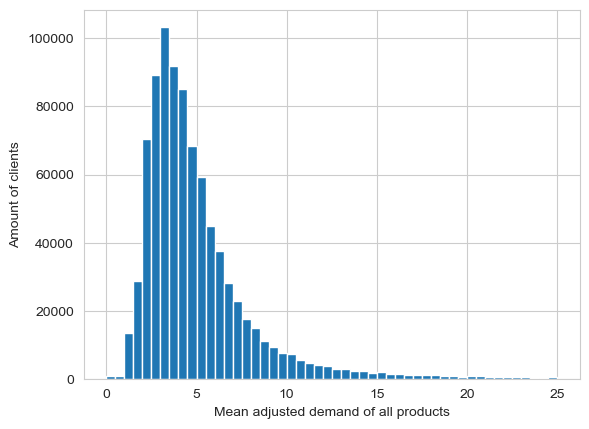

In [75]:
plt.hist(client_stats['adj_dem_mean'], bins=np.linspace(0,25,51))

plt.xlabel("Mean adjusted demand of all products")
plt.ylabel("Amount of clients")

plt.show()

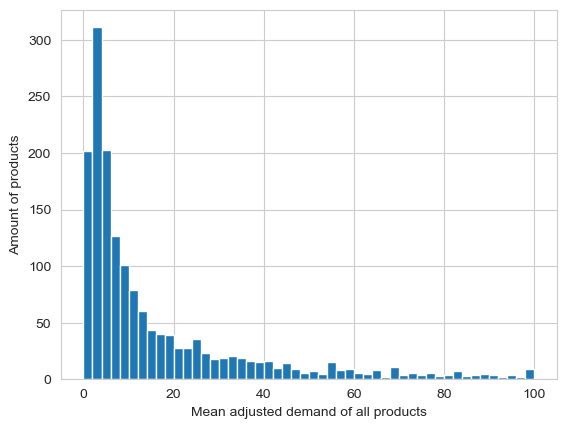

In [66]:
plt.hist(product_stats['adj_dem_mean'], bins=np.linspace(0,100,51))

plt.xlabel("Mean adjusted demand of all products")
plt.ylabel("Amount of products")

plt.show()

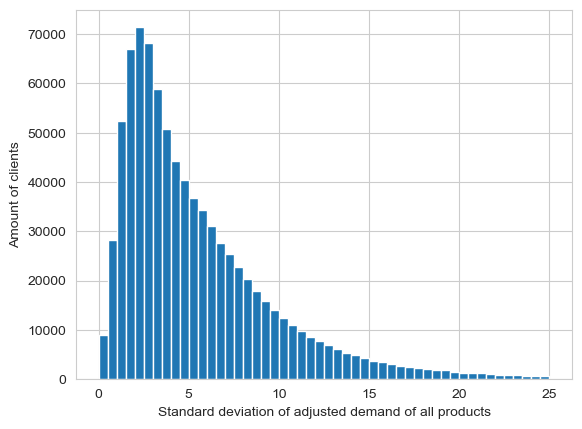

In [76]:
plt.hist(client_stats['adj_dem_std'], bins=np.linspace(0,25,51))

plt.xlabel("Standard deviation of adjusted demand of all products")
plt.ylabel("Amount of clients")

plt.show()

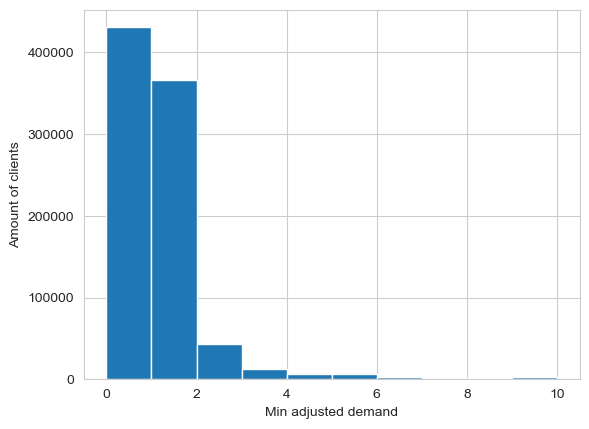

In [68]:
plt.hist(client_stats['adj_dem_min'], bins=np.linspace(0,10,11))

plt.xlabel("Min adjusted demand")
plt.ylabel("Amount of clients")

plt.show()

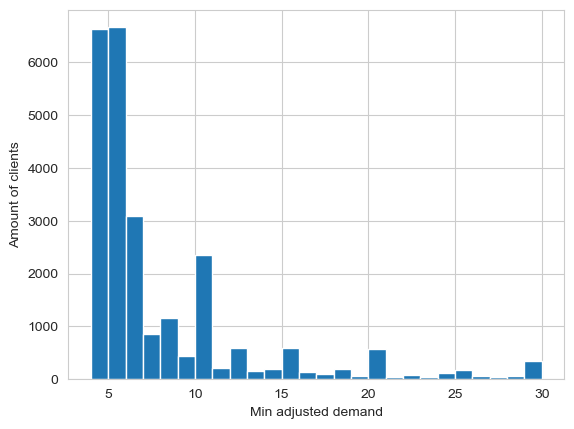

In [85]:
plt.hist(client_stats['adj_dem_min'], bins=np.linspace(4,30,27))

plt.xlabel("Min adjusted demand")
plt.ylabel("Amount of clients")

plt.show()

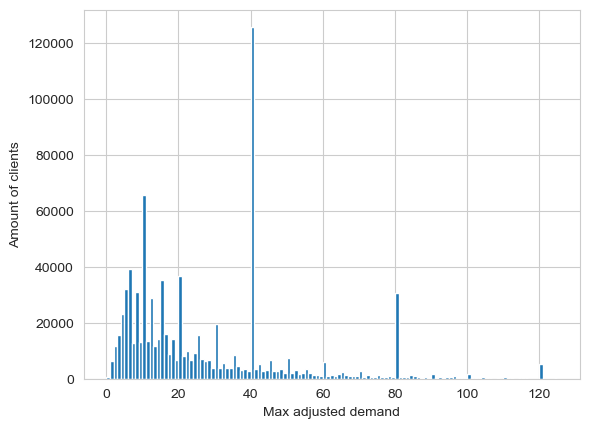

In [74]:
plt.hist(client_stats['adj_dem_max'], bins=np.linspace(0,125,126))

plt.xlabel("Max adjusted demand")
plt.ylabel("Amount of clients")

plt.show()